In [1]:
import numpy as np
from uncertainties import ufloat, unumpy
from uncertainties.umath import *
from astropy.io import fits
from astropy.table import Table
import scipy.stats as st
import pandas
import matplotlib.pyplot as plt
from astropy.stats import LombScargle
from scipy.ndimage.filters import gaussian_filter
from scipy import signal
from importlib import reload as reload
import warnings
warnings.filterwarnings("ignore")

import pulsations as p #PF functions in module but move to notebook to simplify

# set up directories
- note: epoch 2 was the short epoch that we did not end up using
- as such, our usual "NICER epoch 2" is referred to as **epoch 3** in this notebook

In [2]:
datadir = 'NIC_3ep'

#paths to each epoch
e1path = datadir+'/epoch1/'
e2path = datadir+'/epoch2/'
e3path = datadir+'/epoch3/'
#tables of start and end times from each epoch
tep1 = p.readevt(e1path+'epoch1-sun80-spaceweather_bar.evt',ind=2)
tep2 = p.readevt(e2path+'epoch2-sun80-spaceweather_bar.evt',ind=2)
tep3 = p.readevt(e3path+'epoch3-sun80-spaceweather_bar.evt',ind=2)
#corresponding event tables
ep1 = p.readevt(e1path+'epoch1-sun80-spaceweather_bar.evt')
ep2 = p.readevt(e2path+'epoch2-sun80-spaceweather_bar.evt')
ep3 = p.readevt(e3path+'epoch3-sun80-spaceweather_bar.evt')

# exposure times

In [3]:
ep1time = np.sum(tep1['STOP']-tep1['START'])
ep2time = np.sum(tep2['STOP']-tep2['START'])
ep3time = np.sum(tep3['STOP']-tep3['START'])
print(ep1time,ep2time,ep3time)

6464.003115236759 527.9994794428349 3014.9777161478996


# filter to 0.3--8.0 keV

In [4]:
#first epoch
ep1 = ep1[ep1['PI']>=30]
ep1 = ep1[ep1['PI']<=800]
soft_ep1 = ep1[ep1['PI']<=150]
hard_ep1 = ep1[ep1['PI']>150]

#epoch 3
ep3 = ep3[ep3['PI']>=30]
ep3 = ep3[ep3['PI']<=800]
soft_ep3 = ep3[ep3['PI']<=150]
hard_ep3 = ep3[ep3['PI']>150]

# original periodicities

In [5]:
#period for first epoch; variable names from original naming
pd = 68.68201618721699
#period for third epoch
compd = 68.56842782790496

# total, soft, hard band BGs: 3C50


In [6]:
#background percentages for epoch 1 (updated and checked)
ep1_ssub = .136*len(soft_ep1)/ep1time #avg rate * percentage that's BG
ep1_hsub = .208*len(hard_ep1)/ep1time
ep1_tsub = .171*len(ep1)/ep1time
print('soft:',ep1_ssub,'hard:',ep1_hsub,'total:',ep1_tsub)

#also save percentage that's background without converting to rate to subtract
ep1_sper = 0.136
ep1_hper = 0.208
ep1_tper = 0.171

soft: 0.5770739793127981 hard: 0.8830985843036553 total: 1.4515945974534579


In [7]:
#background percentages for epoch 3
ep3_ssub = .233*len(soft_ep3)/ep3time 
ep3_hsub = .339*len(hard_ep3)/ep3time
ep3_tsub = .292*len(ep3)/ep3time
print(ep3_ssub,ep3_hsub,ep3_tsub)

ep3_sper = 0.233
ep3_hper = 0.339
ep3_tper = 0.292

0.5724191561206682 1.049389845588098 1.62126571411124


# function to calculate single rms PF
- pass in count rates and errors
- **function for count rate pulse profile defined right after**

In [8]:
def rms_spf(cr,err,nbins=64,onephase=True,printall=False):
    '''Calculate single rms PF'''
    totlen = len(cr)
    if printall: print('tot len:',totlen)
    if onephase: #only use up to phase 1 in calculation
        cr=cr[:int(totlen/2)] #count rate in phase bins up to 1
        err=err[:int(totlen/2)]
    rerr=unumpy.uarray(cr,err)
#     if printall: print(rerr)
    if printall: print(f'final len: {len(cr)}')
    #phase-averaged count rate
    avgr = np.mean(rerr)
    if printall: print(f'average rate: {avgr}')
    #len(r) is N (number of phase bins)
    num = np.sum(((rerr-avgr)**2))/len(cr)
    if printall: print(len(cr))
    num = (num)**(1/2)
    full = num/avgr
    return full #PFs and errors

In [9]:
def cr_profile(evt,pd,expt,sbg,bins=64,plot=False,color='black'):
    '''Create BG-subtracted count rate pulse profile. Code copied from phashist and s_phaserate functions
    in pulsations module'''
    #convert bg percentage to average bg count rate (which will then be subtracted after converting to count rate)
    pfbg = sbg*len(evt)/expt
    #copied from the phasehist function, which you've seen before
    plt.figure(figsize=(5,4))
    ph = (evt['TIME'])%pd 
    ph_1 = ph/pd #divides phase by period so that x-axis goes to 1, not pd
    ph_2 = ph_1+1 
    ph_3 = list(ph_1)+list(ph_2) #duplicates and concatenates 
    #binning must be done this way to be more precise
    binw = 2./bins
    a = plt.hist(ph_3,bins=np.arange(0,2.01,binw),color=color,histtype='step',label='all')
    plt.xlim(0,2)
    plt.xlabel('Phase',fontsize=14)
    plt.ylabel('Counts',fontsize=14)
    #constructs list of middle of each phase bin
    mids = []
    for t in range(1,len(a[1])):
        mids.append(np.median((a[1][t],a[1][t-1])))
    #adds error as sqrt of counts
    plt.errorbar(mids,a[0],yerr=np.sqrt(a[0]),linestyle='none',color=color)
    #returns histogram (counts and bin boundary arrays), and array of middles of phase bins
    
    plt.close()
    hist = a
    #below: want phase bins (up to 1) not total phase bins -- so divide by 2
    bins /= 2
    
    #now convert to count rate and subtract BG (uses s_phaserate from pulsations module)
    counts = hist[0] #array of counts in each bin 
    binb = hist[1] #array of bin boundaries
    #convert to count rate using exposure time, number of bins; and subtract average bg rate
    cr = (counts*bins/(expt))-pfbg
    hist2 = plt.hist(binb[:-1],binb,weights=cr,color=color,histtype='step')
    err = np.sqrt(counts)*bins/expt
    plt.errorbar(mids,cr,yerr=err,color=color,linestyle='none')
    plt.xlim(0,2)
    plt.xlabel('Phase',fontsize=14)
    plt.ylabel('Counts/s',fontsize=14)
    if not plot: plt.close()

    return cr,err

In [10]:
def both(evt,pd,expt,sbg,bins=64,plot=False,color='black',printall=False):
    '''call both functions above and plot PFs'''
    #get pulse profile count rates and count rate errors
    cr,err = cr_profile(evt,pd,expt,sbg,bins=bins,plot=plot,color=color)
    #calculate rms pulsed fractions
    pf = rms_spf(cr,err,nbins=bins,printall=printall)
    return pf

# define all BG percentages
- space weather and 3C50
- first: BGs for two bins in 3-8 range; then for 1 bin

In [11]:
#3C50 BG percentages in order of energy band; n means "new"
nep1pfbg = [.195,.112,.10,.107,.156,.217,.445]
#epoch 3
nep3pfbg = [.359,.19,.169,.179,.258,.349,.628]
#(just redefined for convenience) percentage from 0.3-8 keV
nep1pfbg_t = .171
nep3pfbg_t = .292

#ep3 soft, hard: .233,.339s
#space weather BGs
ep1pfbg = [0.167,0.088,0.073,0.067,0.071,0.074,0.128]
ep3pfbg = [0.26,0.125,0.098,0.087,0.091,0.08,0.145]
ep1pfbg_t = 0.095
ep3pfbg_t = 0.123

In [12]:
#3C50; s refers to "single (bin in 3-8 keV)"
s_nep1pfbg = [.195,.112,.10,.107,.156,.302]
s_nep3pfbg = [.359,.19,.169,.179,.258,.462]


#space weather
s_ep1pfbg = [0.167,0.088,0.073,0.067,0.071,0.096]
s_ep3pfbg = [0.26,0.125,0.098,0.087,0.091,0.107]

# check suspicious ranges: epoch 1 3-8 keV and 2-3 keV

In [13]:
nep1pfbg[-1]

0.445

In [30]:
onehard = True #one bin between 3 and 8 keV
evt = ep1
en1 = evt[evt['PI']<=70]
en2 = evt[evt['PI']>70]
en2 = en2[en2['PI']<=100]
en3 = evt[evt['PI']>100]
en3 = en3[en3['PI']<=150]
en4 = evt[evt['PI']>150]
en4 = en4[en4['PI']<=200]
en5 = evt[evt['PI']>200]
en5 = en5[en5['PI']<=300]
en6 = evt[evt['PI']>300]
#only one bin 3-8 keV
if onehard: en6 = en6[en6['PI']<=800]
#two bins 3-8 keV
else:
    en6 = en6[en6['PI']<=500]
    en7 = evt[evt['PI']>500]
    en7 = en7[en7['PI']<=800]

tot len: 64
final len: 32
average rate: 1.382+/-0.017
32
RMS PF for 3-8 keV; profile in black 0.398+/-0.012
tot len: 64
final len: 32
average rate: 0.929+/-0.013
32
RMS PF for 2-3 keV; profile in red 0.462+/-0.013


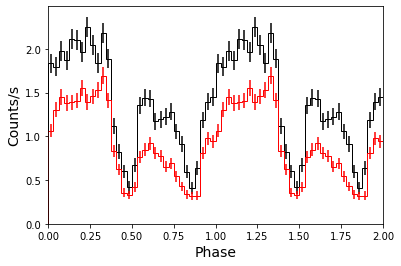

In [31]:
#printall is True gives full calculation
print('RMS PF for 3-8 keV; profile in black',both(en6,pd,ep1time,s_nep1pfbg[-1],bins=64,plot=True,color='black',printall=True))
print('RMS PF for 2-3 keV; profile in red',both(en5,pd,ep1time,s_nep1pfbg[-2],bins=64,plot=True,color='red',printall=True))

# calculate all PFs (six energy bins) for each epoch


In [32]:
ep1_pfs = []
ep1_errs = []
#repeat with space weather bg
ep1_pfs_sw = []
ep1_swerrs = []


bands = [en1,en2,en3,en4,en5,en6]
for i in range(6):
    #use energy band event table and associate bg (3C50)
    pf = both(bands[i],pd,ep1time,s_nep1pfbg[i],bins=64,plot=False,color='black',printall=False)
    #repeat with space weather bg
    pf_sw = both(bands[i],pd,ep1time,s_ep1pfbg[i],bins=64,plot=False,color='black',printall=False)
    pfn,pfe = pf.n,pf.s
    pfn_sw,pfe_sw = pf_sw.n,pf_sw.s
    ep1_pfs.append(pfn)
    ep1_errs.append(pfe)
    ep1_pfs_sw.append(pfn_sw)
    ep1_swerrs.append(pfe_sw)

In [33]:
ep1_pfs

[0.32795789739499254,
 0.4298175716930778,
 0.465103372429604,
 0.4806874402509125,
 0.4618407886231457,
 0.3979429871333349]

In [25]:
#repeat energy tables for epoch 3

onehard = True #one bin between 3 and 8 keV
evt = ep3
en1 = evt[evt['PI']<=70]
en2 = evt[evt['PI']>70]
en2 = en2[en2['PI']<=100]
en3 = evt[evt['PI']>100]
en3 = en3[en3['PI']<=150]
en4 = evt[evt['PI']>150]
en4 = en4[en4['PI']<=200]
en5 = evt[evt['PI']>200]
en5 = en5[en5['PI']<=300]
en6 = evt[evt['PI']>300]
#only one bin 3-8 keV
if onehard: en6 = en6[en6['PI']<=800]
#two bins 3-8 keV
else:
    en6 = en6[en6['PI']<=500]
    en7 = evt[evt['PI']>500]
    en7 = en7[en7['PI']<=800]

In [26]:
ep3_pfs = []
ep3_errs = []
#repeat with space weather bg
ep3_pfs_sw = []
ep3_swerrs = []

bands = [en1,en2,en3,en4,en5,en6]
for i in range(6):
    #use energy band event table and associate bg (3C50)
    pf = both(bands[i],compd,ep3time,s_nep3pfbg[i],bins=64,plot=False,color='black',printall=False)
    pf_sw = both(bands[i],compd,ep3time,s_ep3pfbg[i],bins=64,plot=False,color='black',printall=False)
    pfn,pfe = pf.n,pf.s
    pfn_sw,pfe_sw = pf_sw.n,pf_sw.s
    ep3_pfs.append(pfn)
    ep3_errs.append(pfe)
    ep3_pfs_sw.append(pfn_sw)
    ep3_swerrs.append(pfe_sw)

# calculate PFs from 0.3-8 keV for each BG method for each epoch

In [48]:
ep1sw = both(ep1,pd,ep1time,ep1pfbg_t,bins=64,plot=False,color='black',printall=False)
ep1c = both(ep1,pd,ep1time,nep1pfbg_t,bins=64,plot=False,color='black',printall=False)
ep3sw = both(ep3,compd,ep3time,ep3pfbg_t,bins=64,plot=False,color='black',printall=False)
ep3c = both(ep3,compd,ep3time,nep3pfbg_t,bins=64,plot=False,color='black',printall=False)

In [49]:
ep1sw.n

0.3803073088604867

# plot PFs for each epoch

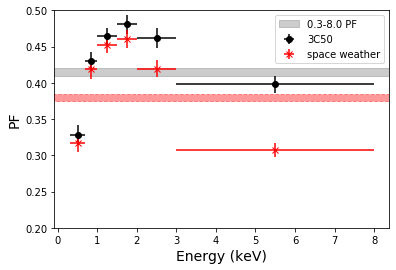

In [56]:
xs = [.5,.85,1.25,1.75,2.5,5.5]
xerr = [.2,.15,.25,.25,.5,2.5]

c50 = ep1_pfs
c50err = ep1_errs
plt.errorbar(xs,c50,yerr=c50err,xerr=xerr,marker='o',linestyle='none',color='black',label='3C50')
plt.errorbar(xs,ep1_pfs_sw,yerr=ep1_swerrs,xerr=xerr,marker='x',linestyle='none',color='red',label='space weather')

#can add space sweather here
# plt.errorbar(xs,sw,yerr=swerr,xerr=xerr,marker='o',linestyle='none',color='red',label='space weather')


plt.xlabel('Energy (keV)',fontsize=14)
plt.ylabel('PF',fontsize=14)

#plot PF for 0.3-8.0
plt.axhspan(ep1c.n-ep1c.s,ep1c.n+ep1c.s,color='grey',alpha=.4,label='0.3-8.0 PF')
plt.axhspan(ep1sw.n-ep1sw.s,ep1sw.n+ep1sw.s,color='red',linestyle='dashed',alpha=.4)
# plt.title('epoch 1 3C50 ')
plt.ylim(0.2,0.5)
plt.legend()
plt.savefig('LXP_69_NICER/0.3-8.0Figs/3Epoch/rmsep1pf.png',dpi=200,bbox_inches='tight')

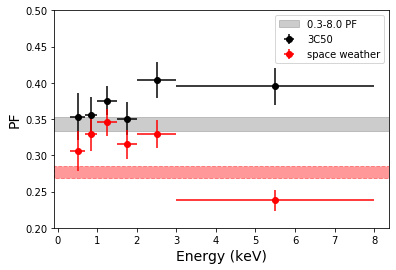

In [54]:
xs = [.5,.85,1.25,1.75,2.5,5.5]
xerr = [.2,.15,.25,.25,.5,2.5]

c50 = ep3_pfs
c50err = ep3_errs
plt.errorbar(xs,c50,yerr=c50err,xerr=xerr,marker='o',linestyle='none',color='black',label='3C50')
plt.errorbar(xs,ep3_pfs_sw,yerr=ep3_swerrs,xerr=xerr,marker='o',linestyle='none',color='red',label='space weather')

#can add space sweather here
# plt.errorbar(xs,sw,yerr=swerr,xerr=xerr,marker='o',linestyle='none',color='red',label='space weather')


plt.xlabel('Energy (keV)',fontsize=14)
plt.ylabel('PF',fontsize=14)

#plot PF for 0.3-8.0
plt.axhspan(ep3c.n-ep3c.s,ep3c.n+ep3c.s,color='grey',alpha=.4,label='0.3-8.0 PF')
plt.axhspan(ep3sw.n-ep3sw.s,ep3sw.n+ep3sw.s,color='red',linestyle='dashed',alpha=.4)

plt.ylim(0.2,0.5)
plt.legend()
plt.savefig('LXP_69_NICER/0.3-8.0Figs/3Epoch/rmsep3pf.png',dpi=200,bbox_inches='tight')

In [57]:
ep1c

0.41517263512513936+/-0.0051314868608079425